In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt, compare_opt, save_opt
import matplotlib.pyplot as plt
import torch 
import numpy as np
from infopath.utils.functions import run_with_perturbation, model_version, feature_pop_avg, mse_2d
import os
from scipy.optimize import linear_sum_assignment
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
import pandas as pd
from infopath.losses import trial_matching_loss, hard_trial_matching_loss
from geomloss import SamplesLoss
from infopath.utils.functions import trial_metric
import random 

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

In [2]:
os.chdir("..")

In [3]:
# set seed for reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True

In [4]:
lick_classifier = torch.load(f"datasets/QuickAccess/lick_classifie_seed{0}.pt")
response_time = 12

In [5]:
logs = [
    "log_dir/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_54_10_l1across200_seed0",
    # Full
    "log_dir/61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_0_57_l1across200_seed3"
    ]
opt_refcirc = load_training_opt(logs[0])
version = model_version(logs[0], "")[0]
model_refcirc = load_model_and_optimizer(opt_refcirc, reload=True, last_best=version)[0]
opt_reconrnn = load_training_opt(logs[1])
version = model_version(logs[1], "")[0]
model_reconrnn = load_model_and_optimizer(opt_reconrnn, reload=True, last_best=version)[0]

filt = lambda x : model_reconrnn.filter_fun2(model_reconrnn.filter_fun1(x))

In [6]:
# # make 1000 trials
# trials = 200
# for i in range(5):
#     seed = i
#     torch.manual_seed(seed)
#     model_reconrnn.rsnn.light_neuron[:] = True
#     light = torch.zeros(model_reconrnn.T, trials, model_reconrnn.opt.n_units).cuda()
#     light.requires_grad_()
#     stims = torch.ones(trials).cuda()
#     stims[:trials//2] = 0
#     spikes_reconrnn, _, jaw_reconrnn, _ = model_reconrnn(stims, light=light)
#     filt_jaw = filt(jaw_reconrnn)
#     lick_reconrnn = lick_classifier(filt_jaw[-response_time:,:,0].T)
#     # lick_reconrnn.sum().backward()
#     filt_jaw.sum().backward()
#     light_grads = light.grad.detach()
#     torch.save(light_grads.detach(), f"datasets/QuickAccess/light_grads_seed{seed}.pt")
#     torch.save(spikes_reconrnn.detach(), f"datasets/QuickAccess/spikes_reconrnn_seed{seed}.pt")
#     torch.save(jaw_reconrnn.detach(), f"datasets/QuickAccess/jaw_reconrnn_seed{seed}.pt")
#     torch.save(lick_reconrnn.detach(), f"datasets/QuickAccess/lick_reconrnn_seed{seed}.pt")

In [7]:
T, K, N = model_reconrnn.T, 1000, model_reconrnn.opt.n_units
light_grads = torch.zeros(T, K, N, device="cuda")
spikes_reconrnn = torch.zeros(T, K, N, device="cuda")
jaw_reconrnn = torch.zeros(T, K, 1, device="cuda")
lick_reconrnn = torch.zeros(K, 1, device="cuda")
per_run = 200
for i in range(5):
    light_grads[:,i*per_run:(i+1)*per_run] = torch.load(f"datasets/QuickAccess/light_grads_seed{i}.pt").detach()
    spikes_reconrnn[:,i*per_run:(i+1)*per_run] = torch.load(f"datasets/QuickAccess/spikes_reconrnn_seed{i}.pt").detach()
    jaw_reconrnn[:, i*per_run:(i+1)*per_run] = torch.load(f"datasets/QuickAccess/jaw_reconrnn_seed{i}.pt").detach()
    lick_reconrnn[i*per_run:(i+1)*per_run] = torch.load(f"datasets/QuickAccess/lick_reconrnn_seed{i}.pt").detach()
filt_jaw_reconrnn = filt(jaw_reconrnn)

In [8]:
trials = 300
seed = 1
with torch.no_grad():
    torch.manual_seed(seed)
    model_refcirc.rsnn.light_neuron[:] = True
    light = torch.zeros(model_refcirc.T, trials, model_refcirc.opt.n_units).cuda()
    light.requires_grad_()
    stims = torch.ones(trials).cuda()
    # stims[trials//2:] = 0
    spikes_refcirc, _, jaw_refcirc, _ = model_refcirc(stims, light=light)
    filt_jaw_refcirc = filt(jaw_refcirc)
    lick_refcirc = lick_classifier(filt_jaw_refcirc[-response_time:,:,0].T)
print(((1-stims)*2 + (lick_refcirc[:,0]>0.5)).unique(return_counts=True))

(tensor([0., 1.], device='cuda:0'), tensor([ 87, 213], device='cuda:0'))


In [9]:
# neural_alignement
stims_zeros = torch.arange(1000).cuda()
stims_zeros[stims_zeros%200<100] = True
stims_zeros[stims_zeros%200>=100] = False
stims_zeros = stims_zeros.bool()
stims_ones = ~stims_zeros

neuron_start, neuron_end = 1000, 1200
fr_x = filt(spikes_reconrnn)[:,stims_zeros, neuron_start:neuron_end].mean((0,1))/model_reconrnn.timestep
fr_y = filt(spikes_refcirc)[:,:,neuron_start:neuron_end].mean((0,1))/model_reconrnn.timestep
filt_reconrnn = filt(filt(spikes_reconrnn))[:,stims_ones,neuron_start:neuron_end]
filt_refcirc = filt(filt(spikes_refcirc))[:,:,neuron_start:neuron_end]

psth_reconrnn = filt_reconrnn.mean(1) 
# psth_reconrnn = (psth_reconrnn - psth_reconrnn.mean(0))/ psth_reconrnn.std(0)
psth_refcirc = filt_refcirc.mean(1)
# psth_refcirc = (psth_refcirc - psth_refcirc.mean(0))/ psth_refcirc.std(0)
with torch.no_grad():
    cost = mse_2d(psth_reconrnn, psth_refcirc)
    cost[fr_x < 2][:, fr_y < 2] = 100
    keepx_neuron, ytox_neuron = linear_sum_assignment(cost.detach().cpu().numpy())

ids_neuron = torch.argsort(cost[keepx_neuron, ytox_neuron], descending=False)

keepx_neuron = torch.tensor(keepx_neuron+neuron_start, device=psth_reconrnn.device)#[keep_topneurons]
ytox_neuron = torch.tensor(ytox_neuron+neuron_start, device=psth_reconrnn.device)#[keep_topneurons]

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


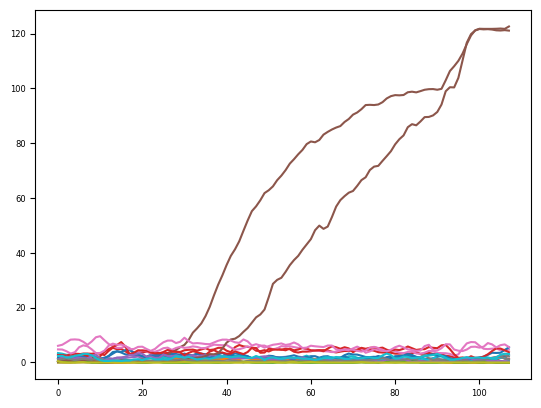

In [10]:

plt.figure()
plt.plot(filt(spikes_reconrnn)[:,stims_ones][:,:, keepx_neuron[:10]].mean(1).cpu()/model_reconrnn.timestep)
plt.gca().set_prop_cycle(None)
# plt.figure()
plt.plot(filt(spikes_refcirc)[:,:, ytox_neuron[:10]].mean(1).cpu()/model_reconrnn.timestep)
# plt.ylim(0,20)


In [11]:
# perfect neuron matching
keepx_neuron = torch.arange(neuron_start, neuron_end, device=psth_reconrnn.device)
ytox_neuron_orig = torch.zeros_like(keepx_neuron)
for i in range(neuron_end-neuron_start):
    n_idx = model_reconrnn.neuron_index[neuron_start+i]
    try:
        ytox_neuron_orig[i] = model_refcirc.neuron_index[neuron_start:neuron_end].tolist().index(n_idx) + neuron_start
    except:
        pass


In [12]:
trials = 200
seed = 1
with torch.no_grad():
    torch.manual_seed(seed)
    model_refcirc.rsnn.light_neuron[:] = True
    light = torch.zeros(model_refcirc.T, trials, model_refcirc.opt.n_units).cuda()
    light.requires_grad_()
    stims = torch.zeros(trials).cuda()
    stims[trials//2:] = 1
    spikes_refcirc, _, jaw_refcirc, _ = model_refcirc(stims, light=light)
    filt_jaw_refcirc = filt(jaw_refcirc)
    lick_refcirc = lick_classifier(filt_jaw_refcirc[-response_time:,:,0].T)
print(((1-stims)*2 + (lick_refcirc[:,0]>0.5)).unique(return_counts=True))

(tensor([0., 1., 2., 3.], device='cuda:0'), tensor([23, 77, 74, 26], device='cuda:0'))


In [13]:
time_stop = int(1/model_reconrnn.timestep) 
print(time_stop)
t_trial_reconrnn, t_trial_refcirc = feature_pop_avg(
    filt(spikes_reconrnn[:time_stop, :, keepx_neuron])/model_reconrnn.timestep,
    filt(spikes_refcirc[:time_stop, :, ytox_neuron])/model_reconrnn.timestep,
    filt(jaw_reconrnn[:time_stop]),
    filt(jaw_refcirc[:time_stop]),
    model_reconrnn.rsnn.area_index[neuron_start:neuron_end],
    model_reconrnn.rsnn.excitatory_index[neuron_start:neuron_end],
    z_score=True,
    )
with torch.no_grad():
    cost = mse_2d(t_trial_reconrnn.T, t_trial_refcirc.T)
    # don't the optimal across just the greedy 
    # keepx_trial, ytox_trial = linear_sum_assignment(cost.detach().cpu().numpy())
    ytox_trial = torch.arange(trials, device=cost.device)
    keepx_trial = torch.min(cost, dim=0)[1]
keepx_trial = torch.tensor(keepx_trial, device=cost.device)
ytox_trial = torch.tensor(ytox_trial, device=cost.device)


500


/tmp/ipykernel_169804/4184313146.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keepx_trial = torch.tensor(keepx_trial, device=cost.device)
/tmp/ipykernel_169804/4184313146.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytox_trial = torch.tensor(ytox_trial, device=cost.device)


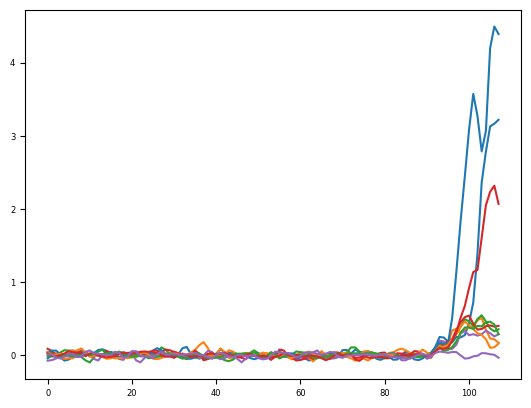

In [14]:
torch.manual_seed(4)
ids_trial = torch.randint(0, trials, (trials,), device=cost.device)[:4]
plt.plot(filt(jaw_reconrnn)[:, keepx_trial[:5],0].cpu())
plt.gca().set_prop_cycle(None)
plt.plot(filt(jaw_refcirc)[:, ytox_trial[:5],0].cpu())

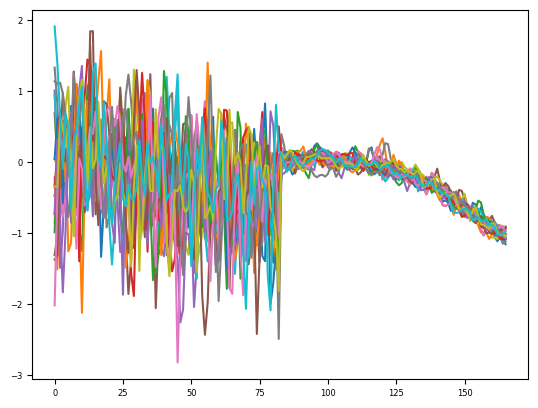

In [15]:
plt.plot(t_trial_reconrnn[keepx_trial[:10]].T.cpu())
plt.gca().set_prop_cycle(None)
plt.plot(t_trial_refcirc[ytox_trial[:10]].T.cpu())


In [20]:
def setup_the_light(trials, lick_reconrnn, keepx_trial, ytox_trial, light_grads,shuffle=True, alwayson=False):
    light_reconrnn = torch.zeros_like(light_grads)
    light_refcirc = torch.zeros_like(light_grads)[:,:trials]
    for stim_trial in range(trials):
        on_off = lick_reconrnn[keepx_trial[stim_trial],0] > 0.5
        grad_level = light_grads[time_stop:time_stop+50, keepx_trial[stim_trial], neuron_start:neuron_end].sum(0)
        increase = torch.argsort(grad_level, descending=True)
        decrease = torch.argsort(grad_level, descending=False)
        to_stim_reconrnn = increase if alwayson else decrease
        if shuffle:
            to_stim_reconrnn = torch.argsort(grad_level.abs(), descending=False)

            # to_stim_reconrnn_best = torch.randperm(neuron_end-neuron_start)[:40]
            # value = grad_level[to_stim_reconrnn_best].sum().abs()
            # for _ in range(200):
            #     to_stim_cand = torch.randperm(neuron_end-neuron_start)[:40]
            #     value_cand = grad_level[to_stim_cand].sum().abs()
            #     if value_cand < value:
            #         to_stim_reconrnn_best = to_stim_cand
            #         value = value_cand
            # to_stim_reconrnn = to_stim_reconrnn_best
        to_stim_reconrnn = to_stim_reconrnn[:40] # at most perturb 40 neurons
        if stim_trial % 50 == 0:
            print("Shuffle", shuffle,"increase", alwayson, grad_level[to_stim_reconrnn].sum())
        to_stim_refcirc = ytox_neuron[to_stim_reconrnn]
        to_stim_reconrnn += neuron_start
        light_reconrnn[time_stop:time_stop+50, keepx_trial[stim_trial], to_stim_reconrnn] = 0.1
        light_refcirc[time_stop:time_stop+50, ytox_trial[stim_trial], to_stim_refcirc] = 0.1
    return light_reconrnn, light_refcirc

In [21]:
# bioRNN & 0.18 $\pm$ 0.02 & 0.19 $\pm$ 0.02 \\
# $\sigma$RNN & 0.16 $\pm$ 0.02 & 0.16 $\pm$ 0.02 \\
# \hline
# No sparsity & 0.19 $\pm$ 0.02 & 0.19 $\pm$ 0.02 \\
# Non-local inhibition & 0.19 $\pm$ 0.02 & 0.18 $\pm$ 0.02 \\
# No Dale's law & 0.19 $\pm$ 0.02 & 0.18 $\pm$ 0.02 \\
# No TM & 0.38 $\pm$ 0.03 & 0.35 $\pm$ 0.03 \\
# No spike & 0.16 $\pm$ 0.02 & 0.17 $\pm$ 0.02 \\

In [22]:
model_reconrnn.rsnn.light_neuron[:] = True
model_refcirc.rsnn.light_neuron[:] = True
deltaJaw_statistics = pd.DataFrame(columns=["shuffle", "alwayson", "change_lick_mean", "change_jaw_mean", "change_lick_std", "change_jaw_std"])
for (shuffle, alwayson) in [(True, None), (False, True), (False, False)]:
    torch.manual_seed(0)
    light_reconrnn, light_refcirc = setup_the_light(trials, lick_reconrnn, keepx_trial, ytox_trial, light_grads, shuffle, alwayson)
    with torch.no_grad():
        seed = 1
        torch.manual_seed(seed)
        spikes_refcirc_light, _, jaw_refcirc_light, _ = model_refcirc(stims, light=light_refcirc)
        filt_jaw_refcirc_light = filt(jaw_refcirc_light)
        lick_refcirc_light = lick_classifier(filt_jaw_refcirc_light[-response_time:,:,0].T)
        change_jaw_mean = (filt_jaw_refcirc_light[:,:,0].sum(0) - filt_jaw_refcirc[:,:,0].sum(0)).mean().item()
        change_lick_mean = ((lick_refcirc_light[:,0]) - (lick_refcirc[:,0])).mean().item()
        change_jaw_std = (filt_jaw_refcirc_light[:,:,0].sum(0) - filt_jaw_refcirc[:,:,0].sum(0)).std().item()
        change_lick_std = ((lick_refcirc_light[:,0]) - (lick_refcirc[:,0])).std().item()
        entry = {"shuffle": shuffle, "alwayson": alwayson, "change_lick_mean": change_lick_mean, "change_jaw_mean": change_jaw_mean, "change_lick_std": change_lick_std, "change_jaw_std": change_jaw_std}
        deltaJaw_statistics = pd.concat([deltaJaw_statistics, pd.DataFrame([entry])])
deltaJaw_statistics

filt_jaw_reconrnn_light = torch.zeros_like(filt_jaw_reconrnn)
lick_reconrnn_light = torch.zeros_like(lick_reconrnn)
for s in range(5):
    with torch.no_grad():
        stims_reconrnn = torch.ones(200).cuda()
        stims_reconrnn[:100] = 0
        torch.manual_seed(s)
        spikes_reconrnn_light, _, jaw_reconrnn_light, _ = model_reconrnn(stims_reconrnn, light=light_reconrnn[:,200*s:200*(s+1)])
        filt_jaw_reconrnn_light[:,200*s:200*(s+1)] = filt(jaw_reconrnn_light)
        lick_reconrnn_light[200*s:200*(s+1)] = lick_classifier(filt_jaw_reconrnn_light[-response_time:,200*s:200*(s+1),0].T)

print("Values for ReconRNN")
print((filt_jaw_reconrnn_light[:,keepx_trial].sum(0) - filt_jaw_reconrnn[:,keepx_trial].sum(0)).mean())
print(((lick_reconrnn[keepx_trial] > 0.5) == (lick_reconrnn_light[keepx_trial]  > 0.5)).sum()/ trials)
print((lick_reconrnn[keepx_trial] > 0.5).sum()/trials, (lick_reconrnn_light[keepx_trial] > 0.5).sum()/trials)
print(filt_jaw_reconrnn[:,keepx_trial].sum(0).mean(), filt_jaw_reconrnn_light[:,keepx_trial].sum(0).mean())

Shuffle True increase None tensor(0.1532, device='cuda:0')
Shuffle True increase None tensor(-0.2268, device='cuda:0')
Shuffle True increase None tensor(-0.0720, device='cuda:0')
Shuffle True increase None tensor(-0.0209, device='cuda:0')
Shuffle False increase True tensor(367.8511, device='cuda:0')
Shuffle False increase True tensor(79.1345, device='cuda:0')
Shuffle False increase True tensor(89.1931, device='cuda:0')
Shuffle False increase True tensor(160.6260, device='cuda:0')
Shuffle False increase False tensor(-292.8432, device='cuda:0')
Shuffle False increase False tensor(-56.1867, device='cuda:0')
Shuffle False increase False tensor(-60.0701, device='cuda:0')
Shuffle False increase False tensor(-125.7473, device='cuda:0')
Values for ReconRNN
tensor(-14.5001, device='cuda:0')
tensor(0.6900, device='cuda:0')
tensor(0.4100, device='cuda:0') tensor(0.1000, device='cuda:0')
tensor(28.6773, device='cuda:0') tensor(14.1773, device='cuda:0')


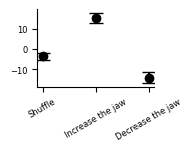

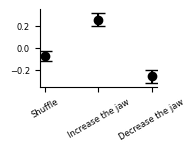

In [23]:
# make error plot for the jaw based on the dataframe deltaJaw_statistics
fig, ax = plot_with_size(30, 20)
ax.errorbar(np.arange(3), deltaJaw_statistics["change_jaw_mean"].values, yerr=1.96*deltaJaw_statistics["change_jaw_std"].values/trials**0.5, fmt="o", capsize=5, color="black")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Shuffle", "Increase the jaw", "Decrease the jaw"])
strip_right_top_axis(ax)
plt.xticks(rotation=30)
fig.savefig("FiguresOpto/Figure5/change_jaw.pdf", bbox_inches="tight", transparent=True)

# make error plot for the jaw based on the dataframe deltaJaw_statistics
fig, ax = plot_with_size(30, 20)
ax.errorbar(np.arange(3), deltaJaw_statistics["change_lick_mean"].values, yerr=1.96*deltaJaw_statistics["change_lick_std"].values/trials**0.5, fmt="o", capsize=5, color="black")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Shuffle", "Increase the jaw", "Decrease the jaw"])
strip_right_top_axis(ax)
plt.xticks(rotation=30)
fig.savefig("FiguresOpto/Figure5/change_lick.pdf", bbox_inches="tight", transparent=True)


In [21]:
reposition = [(0, 200), (1200,1250), (200,400), (1250, 1300), (400, 600), (1300, 1350), (600, 800), (1350, 1400), (800, 1000), (1400, 1450), (1000, 1200), (1450, 1500)]
r = []
for r1 in reposition:
    r.append([i for i in range(r1[0], r1[1])])
r = np.concatenate(r)

def spike_plot(spikes, r, ax, trial=0, alpha=1):
    ax.set_axis_off()
    ax.axvline(0, color="gold", linewidth=0.5)
    ax.axvline(1, color="black", linewidth=0.5)
    color = np.array(["black", "red"])
    tsp, neurid = torch.where(spikes[:,trial,r].cpu())
    tsp = tsp * model_reconrnn.timestep + model_reconrnn.opt.start
    c = ((neurid % 250) > 200).long()
    ax.set_xlim(-0.1, 1.2)
    ax.set_ylim(0, 1500)
    ax.scatter(tsp, neurid, c=color[c], marker="|",s=0.25, linewidth=0.25, alpha=alpha)
    
filtering_time_shrink = filt_jaw_refcirc.shape[0] / jaw_refcirc.shape[0]
def plot_jaw(jaw, trial, ax, filtering_time_shrink=0.5, color="black"):
    plt.axis("off")
    ax.plot(filt(jaw)[:,trial,0].cpu(), color=color, linewidth=0.5)
    ax.axvline(50*filtering_time_shrink, color="gold", linewidth=0.5)
    ax.axvline(550*filtering_time_shrink, color="black", linewidth=0.5)
    ax.set_ylim(-0.2, 6)

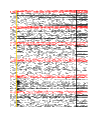

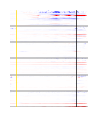

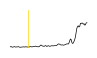

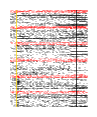

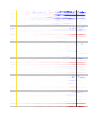

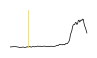

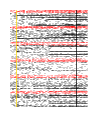

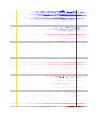

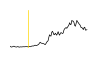

In [22]:
filtering_time_shrink = filt_jaw_refcirc.shape[0] / jaw_refcirc.shape[0]
for i in [101, 117, 102]:
    fig, ax = plot_with_size(20, 25)
    spike_plot(spikes_reconrnn, r, ax, trial=keepx_trial[i])
    fig.savefig(f"FiguresOpto/Figure5/spikes_reconrnn_trial{i}", dpi=600, bbox_inches="tight", pad_inches=0)

    fig, ax = plot_with_size(20, 25)
    plt.axis("off")
    ax.pcolormesh(light_grads[:,keepx_trial[i],r].T.cpu(), cmap="bwr", vmin=-0.5, vmax=0.5)
    ax.set_xlim(0, 650)
    ax.set_ylim(0, 1500)
    for j in range(6):
        ax.axhline(j*250, color="black", linewidth=0.3)
    ax.axvline(50, color="gold", linewidth=0.5)
    ax.axvline(550, color="black", linewidth=0.5)
    fig.savefig(f"FiguresOpto/Figure5/light_grads_reconrnn_trial{i}", dpi=600, bbox_inches="tight", pad_inches=0)

    fig, ax = plot_with_size(20, 10)
    plot_jaw(jaw_reconrnn, keepx_trial[i], ax)
    ax.set_xlim(0, 650*filtering_time_shrink)
    fig.savefig(f"FiguresOpto/Figure5/jaw_reconrnn_trial{i}", dpi=600, bbox_inches="tight", pad_inches=0)


/tmp/ipykernel_15586/1086226275.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"FiguresOpto/Figure5/light_grads_reconrnn_trial{i}_snippet", dpi=300, bbox_inches="tight", pad_inches=0)
/tmp/ipykernel_15586/1086226275.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"FiguresOpto/Figure5/light_grads_reconrnn_trial{i}_snippet_arrowspos", dpi=300, bbox_inches="tight", pad_inches=0)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


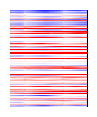

In [23]:
i =117
trial = keepx_trial[i]
fig, ax = plot_with_size(20, 25)
plt.axis("off")
ax.pcolormesh(light_grads[:,trial,r][:,1000:1200].T.cpu(), cmap="bwr", vmin=-0.08, vmax=0.08)
ax.set_xlim(500, 550)
ax.set_ylim(0, 200)
ax.axvline(50, color="gold")
ax.axvline(550, color="black")
fig.set_tight_layout(True)
plt.savefig(f"FiguresOpto/Figure5/light_grads_reconrnn_trial{i}_snippet", dpi=300, bbox_inches="tight", pad_inches=0)


trial = keepx_trial[i]
fig, ax = plot_with_size(2, 25)
plt.axis("off")
# cmap for black white

ax.pcolormesh(~(light_grads[:,trial,r][:,1000:1200].cpu().sum(0)[None].T < -5.3), cmap="gray") # the 5.3 is set so we get at most 40 neurons
fig.set_tight_layout(True)
plt.savefig(f"FiguresOpto/Figure5/light_grads_reconrnn_trial{i}_snippet_arrowspos", dpi=300, bbox_inches="tight", pad_inches=0)



/tmp/ipykernel_15586/2098115797.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}.pdf", dpi=600, bbox_inches="tight", trasparent=True, pad_inches=0)
/tmp/ipykernel_15586/2098115797.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}_rest.pdf", dpi=600, bbox_inches="tight", trasparent=True, pad_inches=0)
/tmp/ipykernel_15586/2098115797.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "color" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}_rest_light.pdf", dpi=600, bbox_inches="tight", color="bl

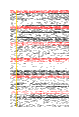

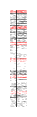

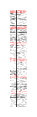

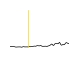

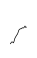

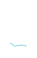

In [26]:
i = 117
stim_trial = ytox_trial[i]
fig, ax = plot_with_size(20*1./1.3, 25)
spike_plot(spikes_refcirc, r, ax, trial=ytox_trial[i])
ax.set_xlim(-0.1, 0.9)
fig.savefig(f"FiguresOpto/Figure5/spikes_refcirc_trial{i}", dpi=600, bbox_inches="tight", pad_inches=0)

fig, ax = plot_with_size(20*0.3/1.3, 25)
spike_plot(spikes_refcirc, r, ax, trial=ytox_trial[i], alpha=0.5)
ax.set_xlim(0.9, 1.2)
fig.savefig(f"FiguresOpto/Figure5/spikes_refcirc_trial{i}_rest", dpi=600, bbox_inches="tight", pad_inches=0, transparent=True)

fig, ax = plot_with_size(20*0.3/1.3, 25)
spike_plot(spikes_refcirc_light, r, ax, trial=ytox_trial[i], alpha=0.5)
ax.set_xlim(0.9, 1.2)
fig.savefig(f"FiguresOpto/Figure5/spikes_refcirc_trial{i}_rest_light", dpi=600, bbox_inches="tight", pad_inches=0, transparent=True)


fig, ax = plot_with_size(20*1./1.3, 10)
plot_jaw(jaw_refcirc, ytox_trial[i], ax)
ax.set_xlim(0*filtering_time_shrink, 500*filtering_time_shrink)
fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}.pdf", dpi=600, bbox_inches="tight", trasparent=True, pad_inches=0)

fig, ax = plot_with_size(20*0.3/1.3, 10)
plot_jaw(jaw_refcirc, ytox_trial[i], ax)
ax.set_xlim(500*filtering_time_shrink, 650*filtering_time_shrink)
fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}_rest.pdf", dpi=600, bbox_inches="tight", trasparent=True, pad_inches=0)

fig, ax = plot_with_size(20*0.3/1.3, 10)
plot_jaw(jaw_refcirc_light, ytox_trial[i], ax, color="#6FCCDD")
ax.set_xlim(500*filtering_time_shrink, 650*filtering_time_shrink)
fig.savefig(f"FiguresOpto/Figure5/jaw_refcirc_trial{i}_rest_light.pdf", dpi=600, bbox_inches="tight", color="blue", trasparent=True, pad_inches=0)
